In [1]:
import os

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib.ticker import PercentFormatter
from epiweeks import Week
from datetime import datetime, timedelta
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
import numpy as np
from utils import timeseries_formatting, basic_formatting, dec_to_date, hpd, _toYearFraction, skipped_timeseries_formatting
from dendropy import TreeList, Tree
import time
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.signal import savgol_filter

prop = mpl.font_manager.FontProperties('Roboto')
mpl.rcParams['font.sans-serif'] = prop.get_name()
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.size']=16

COLOR = '#343434'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

colors = {
    "Rest of World" : "#0072B2",
    "Mexico" : "#56B4E9",
    "Baja California" : "#009E73",
    "San Diego" : "#009E73",
    "Los Angeles" : "#E69F00",
    "United States" : "#D55E00"
}

# Figure 2: Timing and magnitude of Markov jumps into San Diego
Using a discrete phylogeographic analysis, we count the number of markov jumps into San Diego.

Load in the jumps from the discrete state analysis which used actual location states. This table is generated by running the `TreeMarkovJumpHistoryAnalyzer` on the posterior distribution of trees from the discrete-state reconstruction performed with BEAST.

In [2]:
jumps = pd.read_csv( "../data/2022-11-17_exponential_fixed_discete.Location.csv.gz" )
jumps["date"] = jumps["time"].apply( dec_to_date )
jumps["date"] = jumps["date"].dt.normalize()
#jumps = jumps.loc[jumps["treeId"]>jumps["treeId"].max()*0.1]
jumps.head()

,treeId,startLocation,endLocation,time,date
0,100000,San Diego,Rest of World,2021.758713,2021-10-04
1,100000,Los Angeles,San Diego,2021.716796,2021-09-19
2,100000,Los Angeles,Rest of World,2021.685917,2021-09-08
3,100000,Los Angeles,Rest of World,2022.173730,2022-03-05
4,100000,Baja California,Rest of World,2022.447257,2022-06-13


Calculate the number of jumps between San Diego and each other discrete state. This generates Figure 2B.

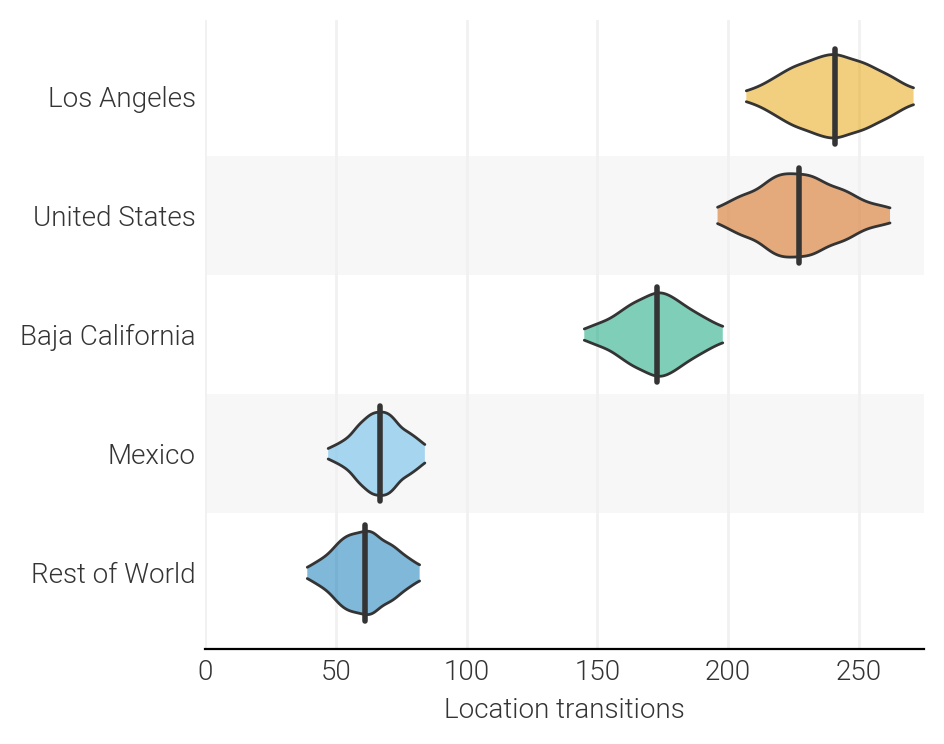

In [3]:
location = "San Diego"

sd_jumps = jumps.loc[(jumps["startLocation"]==location)|(jumps["endLocation"]==location)].copy()
sd_jumps.loc[sd_jumps["endLocation"]==location,"endLocation"] = sd_jumps["startLocation"]
sd_jumps["startLocation"] = location
sd_jumps = sd_jumps.groupby( ["treeId","endLocation"] )["time"].agg( "count" ).reset_index()

def plot_jumps_between( ax, j ):
    for i, query in enumerate( j.groupby( "endLocation" )["time"].median().sort_values().index ):
        data = j.loc[j["endLocation"]==query,"time"].to_numpy().ravel()
        data = data[~np.isnan(data)]
        data_median = np.median( data )

        hpdHi, hpdLo = hpd( data, 0.95 )
        x_grid = np.linspace( hpdLo, hpdHi, 101 )

        kde = gaussian_kde( data )
        y_grid = kde.evaluate( x_grid )
        y_grid = y_grid / y_grid.max() * 0.35

        ax.plot(x_grid, [i+y for y in y_grid], color=COLOR, lw=1, zorder=101, solid_capstyle="round" )
        ax.plot(x_grid, [i-y for y in y_grid], color=COLOR, lw=1, zorder=101, solid_capstyle="round" )

        ax.fill_between( x_grid, [i-y for y in y_grid], [i+y for y in y_grid], facecolor=colors[query], edgecolor='none', alpha=0.5, zorder=100 )
        ln = ax.vlines( data_median, i-0.4, i+0.4, color=COLOR, linewidth=2, zorder=110)
        ln.set_capstyle( "round" )

    ax.set_yticks( range( len( j.groupby( "endLocation" )["time"].median().sort_values().index ) ) )
    ax.set_yticklabels( j.groupby( "endLocation" )["time"].median().sort_values().index )

    ax.axhspan( 0.5,1.5, color=COLOR, alpha=0.04, edgecolor=None, linewidth=0 )
    ax.axhspan( 2.5,3.5, color=COLOR, alpha=0.04, edgecolor=None, linewidth=0 )

    basic_formatting( ax, spines=["bottom"], which="x", xlabel="Location transitions", ysize=10, xsize=10, xlims=(0, 275) )
    ax.tick_params( axis="x", bottom=False, which="both", rotation=0, pad=0 )

fig, ax = plt.subplots( dpi=200, figsize=(5,4) )
plot_jumps_between( ax, sd_jumps )
plt.tight_layout()
plt.savefig( "../analyses/plots/figure2_jumps-into-san-diego.pdf" )
plt.show()

Here we calculate the RMSE between each locations' introduction profile and San Diego's for each tree in the posterior distribution. These results are robust to the error metric used, as we've also used mean absolute error.

In [4]:
def rmse( entry1, entry2 ):
    result = np.power( entry1 - entry2, 2 )
    result = np.average( result )
    return  np.sqrt( result )

def mae( entry1, entry2 ):
    result = np.abs( entry1 - entry2 )
    return np.average( result )

def cosine( entry1, entry2 ):
    result =  np.dot( entry1, entry2 ) / ( np.linalg.norm( entry1 ) * np.linalg.norm( entry2 ) )
    return 1 - result

def get_comparison( pair, mat ):
    try:
        first = mat.loc[~mat.index.isin( pair ),pair[0]]
        second = mat.loc[~mat.index.isin( pair ),pair[1]]
    except KeyError:
        return np.nan
    return rmse( first, second )

results = {
    "Baja California" : [],
    "Los Angeles" : [],
    "Mexico" : [],
    "United States" : [],
    "Rest of World" : []
}

test = jumps.pivot_table( index="startLocation", columns=["treeId", "endLocation"], values="time", aggfunc="count", fill_value=0 )
test = test / test.sum()
for i, df in test.groupby(level=0, axis=1 ):
    for loc in results.keys():
        results[loc].append( get_comparison( (loc, "San Diego" ), df.droplevel( 0, axis=1 ) ) )

results = pd.DataFrame( results )
results.describe( percentiles=[0.025,0.5,0.975])

,Baja California,Los Angeles,Mexico,United States,Rest of World
count,1801.000000,1801.000000,1801.000000,1801.000000,1801.000000
mean,0.168556,0.065472,0.124275,0.075947,0.099709
std,0.015236,0.015028,0.018332,0.012600,0.016966
min,0.113660,0.016441,0.069186,0.033840,0.047694
2.5%,0.139283,0.037715,0.090227,0.051035,0.068032
50%,0.168296,0.065008,0.123804,0.075860,0.099612
97.5%,0.197541,0.096179,0.161005,0.101774,0.135013
max,0.212913,0.115526,0.185373,0.118507,0.159283


To determine how much similar introduction sources play a role in the viral similarity between locations, we compare each locations' introduction profile to San Diego's using RMSE. We plot example profiles from one tree of the posteriod below.

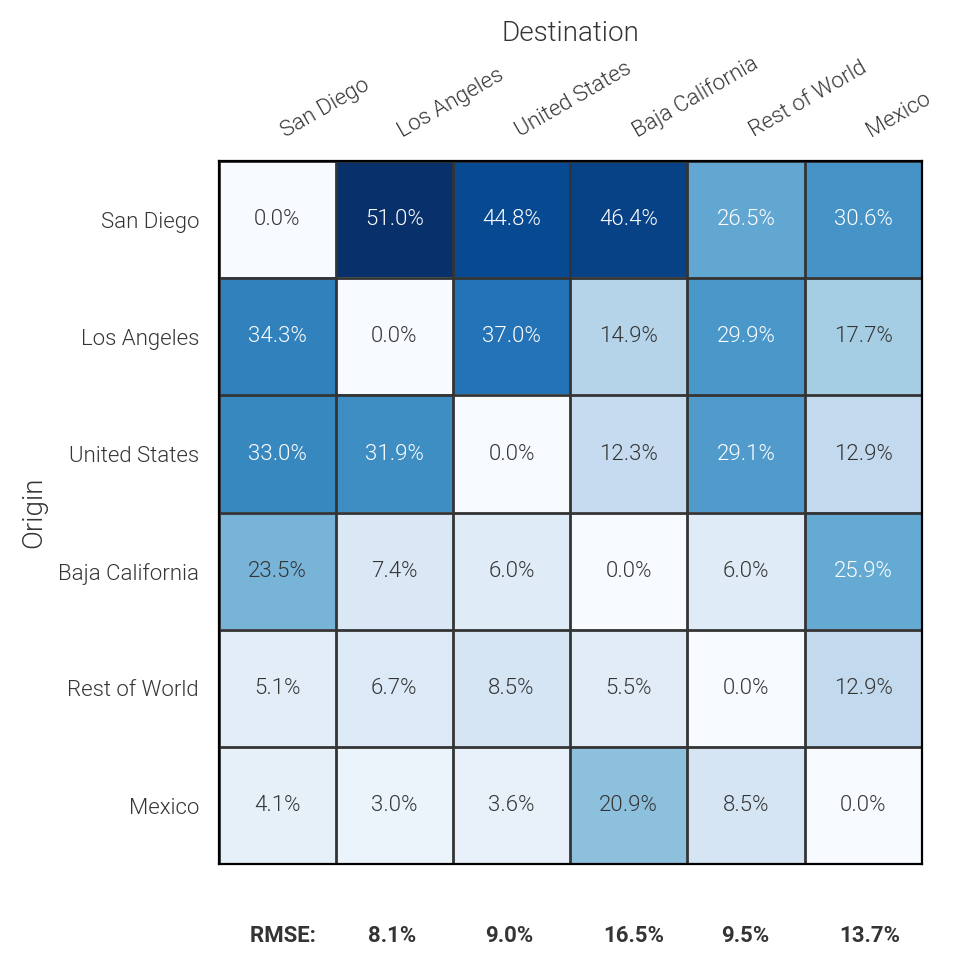

In [5]:
# Plot the results from one tree as a supplimental figure to describe the RMSE analysis.
example = test[np.random.choice( test.columns.get_level_values("treeId") )]
col_order = ["San Diego", "Los Angeles", "United States", "Baja California", "Rest of World", "Mexico"]
example = example.reindex( columns=col_order, index=col_order )

fig, ax = plt.subplots( dpi=200, figsize=(5,5) )
ax.imshow( example, cmap="Blues", vmin=0, vmax=0.5 )

ax.set_xticks( range( len( col_order ) ) )
ax.set_xticklabels( col_order, ha="left" )
ax.set_xlabel( "Destination", fontsize=10 )
ax.xaxis.set_label_position('top')
ax.set_yticks( range( len( col_order ) ) )
ax.set_yticklabels( col_order )
ax.set_ylabel( "Origin", fontsize=10 )

ax.tick_params( axis="x", rotation=30, labelbottom=False, labeltop=True )

for i in range( len( col_order ) ):
    for j in range( len( col_order ) ):
        value = example[col_order[i]][col_order[j]]
        ax.text(i, j, f"{value:.1%}", ha="center", va="center", color=COLOR if value < 0.25 else "w", fontsize=8 )

for i, loc in enumerate( col_order ):
    if loc != "San Diego":
        rmse_res = get_comparison( (loc, "San Diego"), example )
        fig.text( 0.275 + 0.118 * i, 0, f"{rmse_res:.1%}", fontweight="bold", fontsize=8 )

fig.text(0.275, 0, "RMSE: ", fontweight="bold", fontsize=8 )

ax.set_xticks(np.arange(example.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(example.shape[0]+1)-.5, minor=True)
ax.tick_params( axis="y", which="both", labelsize=8, left=False )
ax.tick_params( axis="x", which="both", labelsize=8, bottom=False )
ax.grid(False)
ax.grid(which="minor", color=COLOR, linestyle='-', linewidth=1)

ax.set_ylim( 5.5, -0.5)
ax.set_xlim(-0.5, 5.5)

plt.tight_layout()
#fig.savefig( "../analyses/plots/figureS8_rmse-diagram.pdf" )
#fig.savefig( "../paper/figures/suppfigure8.pdf" )
#fig.savefig( "../paper/figures/suppfigure8.png" )
plt.show()

We plot the RMSE distribution for each location. This generates Figure 2C.

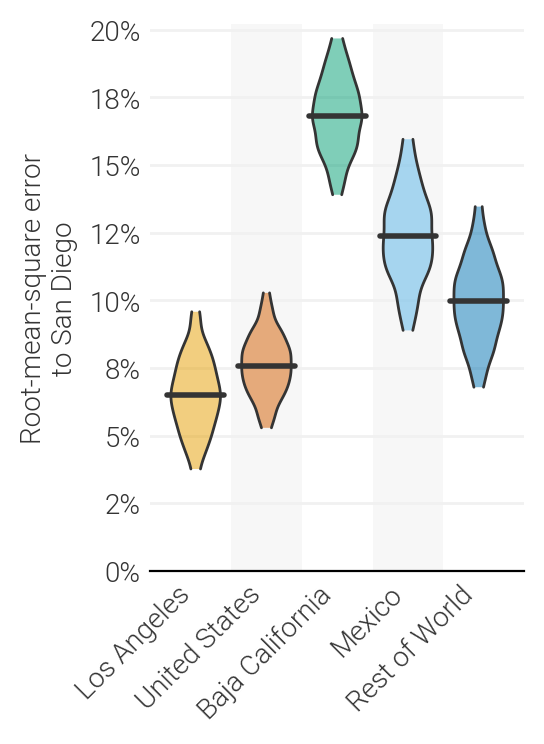

In [6]:
def plot_introduction_sources( ax, results ):
    for i, query in enumerate( results.columns ):
        data = results[query].to_numpy().ravel()
        data = data[~np.isnan(data)]
        data_median = np.median( data )

        hpdHi, hpdLo = hpd( data, 0.95 )
        y_grid = np.linspace( hpdLo, hpdHi, 101 )

        kde = gaussian_kde( data )
        x_grid = kde.evaluate( y_grid )
        x_grid = x_grid / x_grid.max() * 0.35

        ax.fill_betweenx( y_grid, [i-x for x in x_grid], [i+x for x in x_grid], edgecolor='none', alpha=0.5, zorder=99, facecolor=colors[query] )
        ax.plot( [i+x for x in x_grid], y_grid, color=COLOR, lw=1, zorder=100, solid_capstyle="round" )
        ax.plot( [i-x for x in x_grid], y_grid, color=COLOR, lw=1, zorder=100, solid_capstyle="round" )
        ln = ax.hlines( data_median, i-0.4, i+0.4, color=COLOR, linewidth=2, zorder=110)
        ln.set_capstyle( "round" )

    ax.set_xticks( range( len( results.columns ) ) )
    ax.set_xticklabels( results.columns, ha="right" )

    ax.axvspan( 0.5,1.5, color=COLOR, alpha=0.04, edgecolor=None, linewidth=0 )
    ax.axvspan( 2.5,3.5, color=COLOR, alpha=0.04, edgecolor=None, linewidth=0 )

    basic_formatting( ax, which="y", ylabel="Root-mean-square error\nto San Diego", ysize=10, xsize=10, ylims=(0,0.202) )
    ax.tick_params( axis="x", bottom=False, which="both", rotation=45, pad=0 )
    ax.yaxis.set_major_formatter( ticker.PercentFormatter( xmax=1, decimals=0 ) )

fig, ax = plt.subplots( dpi=200, figsize=(3,4) )
results = results.reindex( columns=sd_jumps.groupby( "endLocation" )["time"].median().sort_values( ascending=False ).index )
plot_introduction_sources( ax, results )
plt.tight_layout()
plt.savefig( "../analyses/plots/figure2_introduction-sources-sd.pdf" )
plt.show()

It is easier to place these panels in the figure if we have pyplot align them beforehand.

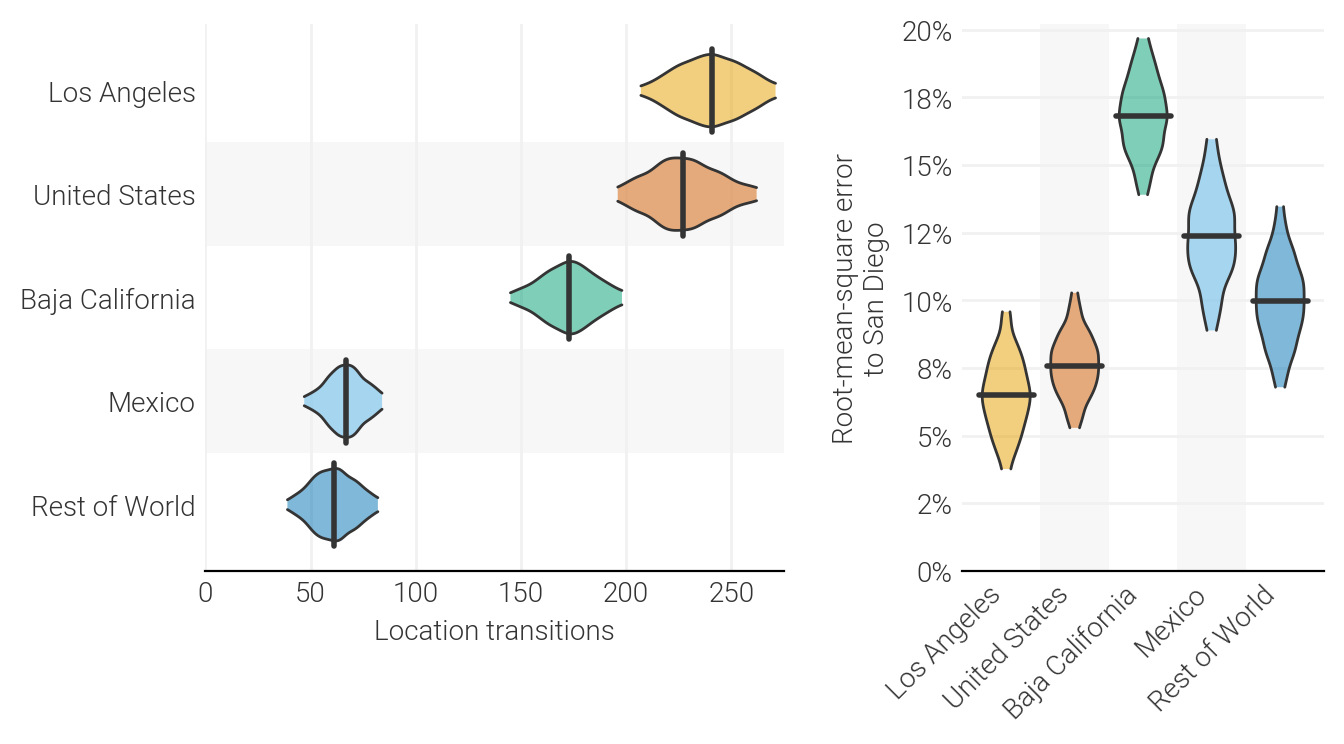

In [7]:
fig, ax = plt.subplots( dpi=200, figsize=(7,4), ncols=2, gridspec_kw={"width_ratios" : (2,1.25)} )
plot_jumps_between( ax[0], sd_jumps )
plot_introduction_sources( ax[1], results )
plt.tight_layout()
plt.savefig( "../analyses/plots/figure2_jumps-sources-into-san-diego.pdf" )
plt.show()

Next we look at the temporal distribution of Markov jumps between San Diego and all other locations. This will be Figure 2D.

/Users/natem/Dropbox (Scripps Research)/Personal/Code/Projects/project_2021_california-hcov-genomics/analyses/utils.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels )
/var/folders/yk/ygy5y6t17g7gptxs3pqtrp240000gn/T/ipykernel_19923/3672369288.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


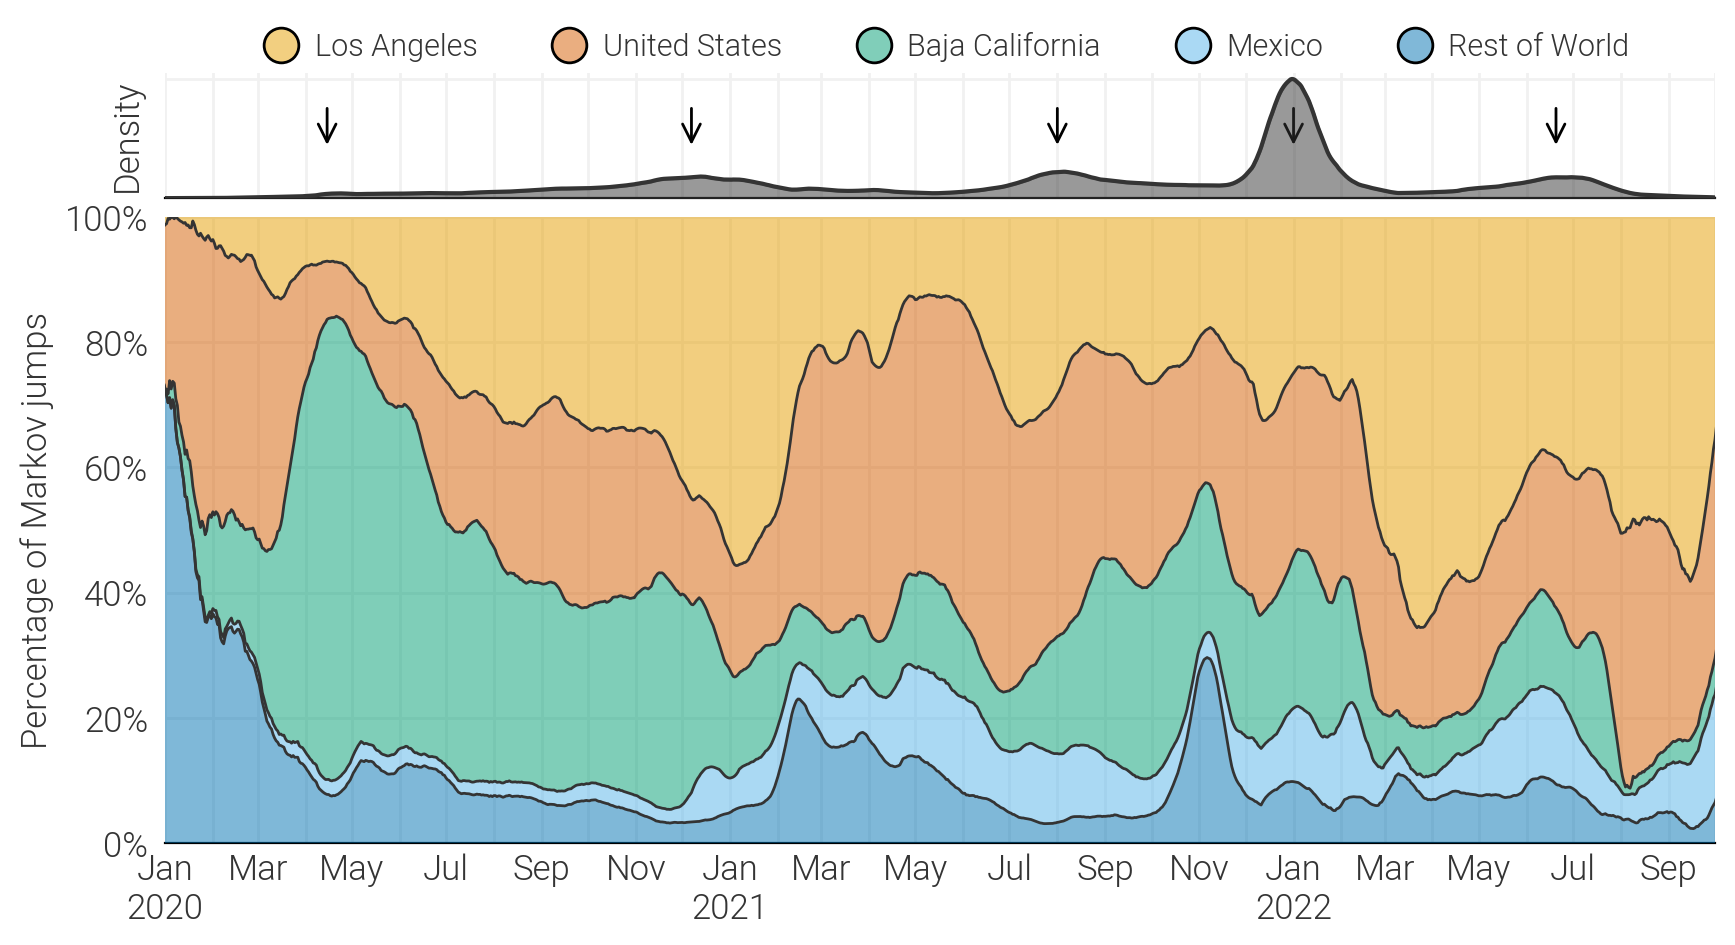

In [8]:
location = "San Diego"

sd_jumps = jumps.loc[(jumps["startLocation"]==location)|(jumps["endLocation"]==location)].copy()
sd_jumps.loc[sd_jumps["endLocation"]==location,"endLocation"] = sd_jumps["startLocation"]
sd_jumps["startLocation"] = location
plot_df = sd_jumps.pivot_table( index="date", columns="endLocation", values="startLocation", aggfunc="count", fill_value=0 )
plot_df = plot_df.apply( lambda x: savgol_filter( x, window_length=31, polyorder=3 ) )
plot_df = plot_df.clip( lower=0 )
plot_df = plot_df.apply( lambda x: x / x.sum(), axis=1 )
plot_df = plot_df.reindex( columns=sd_jumps["endLocation"].value_counts().sort_values().index )

jumps_mag = sd_jumps.pivot_table( index="date", values="startLocation", aggfunc="count", fill_value=0 )
jumps_mag["startLocation"] = savgol_filter( jumps_mag["startLocation"], window_length=31, polyorder=3 )
jumps_mag = jumps_mag / jumps_mag.max()

fig, ax = plt.subplots( figsize=(10,5), dpi=200, nrows=2, sharex=True, gridspec_kw={"height_ratios" : (0.2, 1), "hspace" : 0.05} )
ax[0].plot( jumps_mag.index, jumps_mag["startLocation"], color=COLOR, zorder=9 )
ax[0].fill_between( jumps_mag.index, jumps_mag["startLocation"], color=COLOR, alpha=0.5, zorder=8 )

for period in ["2020-04-15", "2020-12-07", "2021-08-01", "2022-01-01", "2022-06-20"]:
    #ax[0].text( pd.to_datetime(period), 0.6, "↓", ha="center", va="center", color=COLOR )
    #ax[0].arrow( pd.to_datetime(period), 0.6, 0, -0.2, width=0.2)
    ax[0].annotate("", xy=(pd.to_datetime(period), 0.4), xytext=(pd.to_datetime(period), 0.8), arrowprops=dict(arrowstyle="->"))
    
ax[1].stackplot( plot_df.index, plot_df.T, labels=plot_df.columns, zorder=9, colors=[colors[i] for i in plot_df.columns], alpha=0.5, linewidth=2 )

baseline = np.zeros( len( plot_df ))
for i in plot_df:
    if i != plot_df.columns[-1]:
        ax[1].plot( plot_df.index, plot_df[i] + baseline, color=COLOR, zorder=10, linewidth=1 )
        baseline += plot_df[i]

legend = []
for col in reversed( plot_df.columns ):
    legend.append( Line2D([0], [0], linestyle='none', marker='o', color=colors[col] + "7F", markeredgecolor="black", label=col, markersize=12.5 ) )

ax[0].legend( handles=legend, loc="upper center", bbox_to_anchor=(0,0,1,1.55), handletextpad=0.1, frameon=False, fontsize=11, ncol=len( legend ) )
basic_formatting( ax[1], spines=["bottom"], which="both", xlims=( pd.to_datetime("2020-01-01"), pd.to_datetime("2022-10-01") ), ylims=(0,1), ylabel="Percentage of Markov jumps", xsize=12.5, ysize=12.5 )
skipped_timeseries_formatting( ax[1] )
ax[1].yaxis.set_major_formatter( ticker.PercentFormatter(xmax=1) )
ax[1].tick_params( axis="y", pad=2.5 )

basic_formatting( ax[0], spines=["bottom"], which="both", ylims=(0,1.05), ylabel="Density", ysize=12.5, xsize=12.5 )
skipped_timeseries_formatting( ax[0] )
ax[0].set_yticks( [0, 1] )
ax[0].set_yticklabels( [] )
ax[0].label_outer()

plt.tight_layout()
plt.savefig( "../analyses/plots/figure2_jumps-between-sd-relative.pdf" )
plt.show()

# Asymmetrical Model

The above analysis was performed assuming that transition rates where symmetrical. To determine how this assumption influences our results we performed the same analysis assuming asymmetrical rates.

First we load the data from the BEAST run using asymmetrical transition rates.

In [9]:
jumps = pd.read_csv( "../data/2022-11-17_exponential_fixed_discrete_asym.Location.history.csv" )
jumps["date"] = jumps["time"].apply( dec_to_date )
jumps["date"] = jumps["date"].dt.normalize()
#jumps = jumps.loc[jumps["treeId"]>jumps["treeId"].max()*0.1]
jumps.head()

,treeId,startLocation,endLocation,time,date
0,100000,San Diego,Rest of World,2021.859132,2021-11-10
1,100000,United States,Rest of World,2021.777034,2021-10-11
2,100000,San Diego,United States,2021.665609,2021-08-31
3,100000,San Diego,Rest of World,2022.017120,2022-01-07
4,100000,United States,Rest of World,2022.172335,2022-03-04


We assess whether the relative number of jumps between San Diego and each other location is consistent.

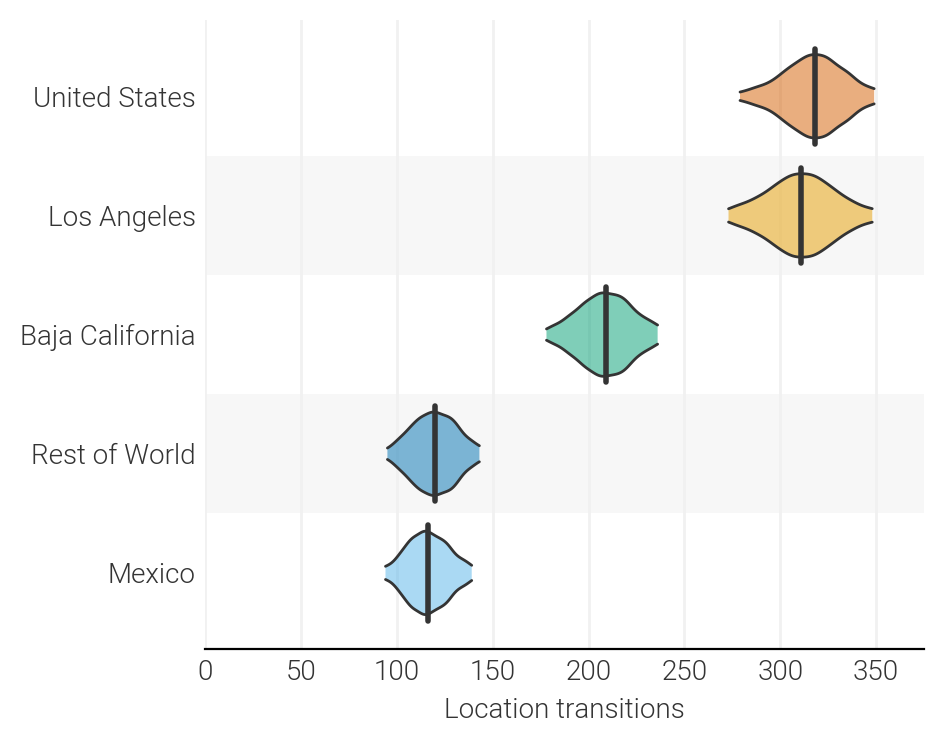

In [14]:
location = "San Diego"

sd_jumps = jumps.loc[(jumps["startLocation"]==location)|(jumps["endLocation"]==location)].copy()
sd_jumps.loc[sd_jumps["endLocation"]==location,"endLocation"] = sd_jumps["startLocation"]
sd_jumps["startLocation"] = location
sd_jumps = sd_jumps.groupby( ["treeId","endLocation"] )["time"].agg( "count" ).reset_index()


fig, ax = plt.subplots( dpi=200, figsize=(5,4) )
plot_jumps_between( ax, sd_jumps )
ax.set_xlim( 0, 375 )
plt.tight_layout()
fig.savefig( "../paper/figures/suppfigure13.pdf" )
fig.savefig( "../paper/figures/suppfigure13.png" )
plt.show()